In [2]:
import music21
import torch
import plotly.graph_objects as go
import json
import numpy as np
from utils import ChoraleChords, plot_embedding_space, plot_details, getTopKAsMultiHot, tensor2midi #, plot_interleaved
from VAEModels import GaussianVAE
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec

np.random.seed(1)
device = "cpu" # "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
# 13k 430


Using cpu device


In [3]:
testset = ChoraleChords(augmented=True)
testset.encoding = 'multi_hot'
testset.original_mh.shape

torch.Size([6235, 128])

In [20]:
testset[:].shape

torch.Size([223535, 128])

In [110]:
t = torch.zeros([2, 10])
mh = torch.zeros([2, 128])
mh1s = torch.ones([2,128])
nt = torch.nested.nested_tensor([[1,2,3], [1,2,3,4,5]], dtype=torch.int64, requires_grad=False, pin_memory=True) + 3.
ntp = torch.nested.to_padded_tensor(nt, 0.0, output_size=[2,10]).to(torch.int64)
print(ntp)
print(torch.nonzero(ntp))
print(mh.scatter_(1, ntp, mh1s))



tensor([[4, 5, 6, 0, 0, 0, 0, 0, 0, 0],
        [4, 5, 6, 7, 8, 0, 0, 0, 0, 0]])
tensor([[0, 0],
        [0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [1, 3],
        [1, 4]])
tensor([[1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.

In [10]:
def plot_reconstructed(model, dim, dim2, r0=(-1, 1), n=25):
    norm = torch.distributions.Normal(0, 1)
    columns = torch.tensor([])
    coords = torch.zeros([n, 10])
    coords[:, dim] = norm.sample([n]) # ).values #np.linspace(*r0, n
    #for i, y in enumerate(np.linspace(*r0, n)):
    #    coords[i,dim] = y
    outs = model.decoder(coords).unique(dim=1)

    x_hat = getTopKAsMultiHot(outs, 4).unique(dim=0)# + outs
    print(x_hat)
    columns = torch.squeeze(x_hat) # torch.cat([columns, torch.unsqueeze(x_hat, dim=0)], dim=0)
    #plt.imshow(columns, extent=[*r0, *r1])
    #columns = torch.squeeze(columns)
    plt.imshow(columns.T.detach().numpy(), cmap='gray', aspect='auto', interpolation='nearest')
    return columns

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
torch.Size([13, 128])
[124, 125, 126, 127]
[123, 125, 126, 127]
[122, 125, 126, 127]
[122, 124, 125, 127]
[122, 123, 124, 125]
[117, 125, 126, 127]
[103, 125, 126, 127]
[103, 117, 126, 127]
[67, 103, 126, 127]
[51, 115, 122, 124]
[40, 51, 83, 122]
[11, 40, 51, 122]
[2, 11, 40, 51]


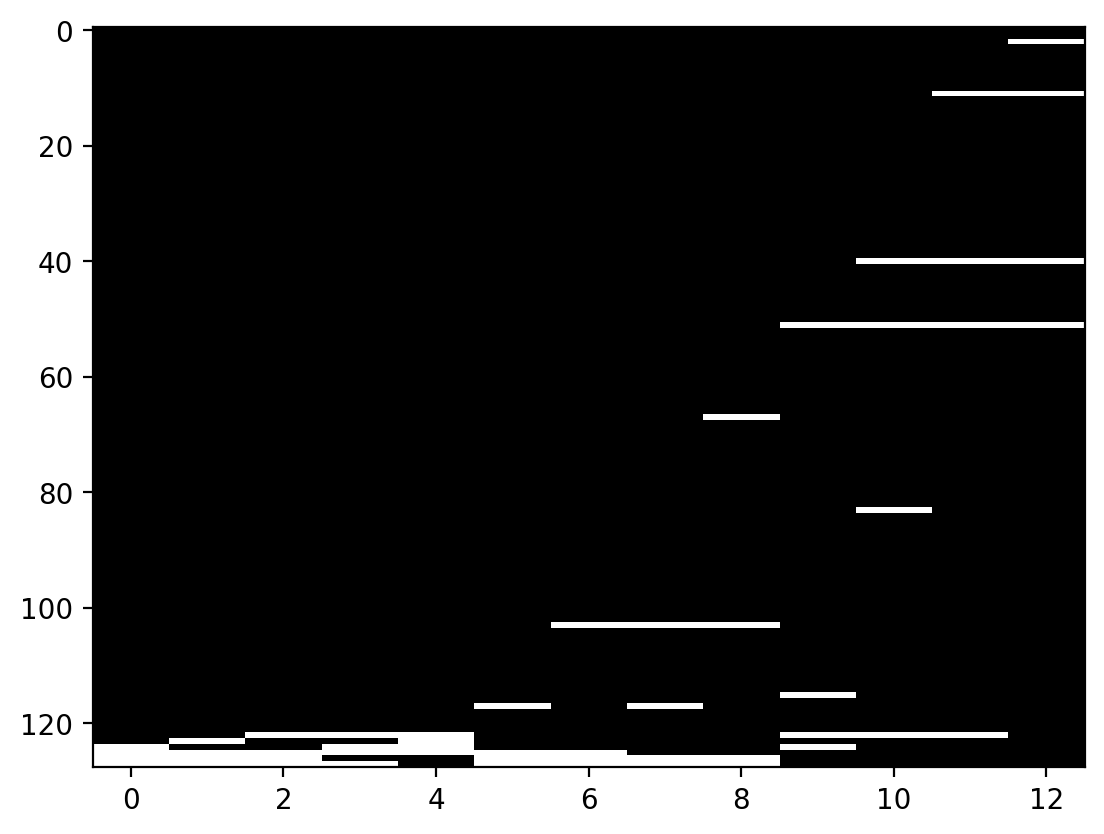

In [13]:
cols = plot_reconstructed(model, 3, 1, r0=(-10, 10), n=100)
print(cols.shape)
cols = cols
for m in tensor2midi(cols).tolist():
    play_midi_chord(m)

tensor([[ 4.0243e-01,  4.5029e-01, -1.0526e+00,  1.8841e-01,  4.8360e-02,
          1.0767e+00,  2.0365e-01, -9.5233e-02,  2.6118e-01, -5.4355e-01],
        [ 7.6914e-01,  7.6855e-01, -4.0674e-01, -3.5448e-01,  5.9769e-01,
          1.4465e+00, -1.7480e-01,  8.8292e-02,  7.7925e-01,  4.6388e-01],
        [ 8.2062e-01, -6.7253e-02, -7.7271e-01,  1.7944e-01,  1.0115e+00,
          1.4946e+00, -3.5522e-01,  8.0625e-01, -4.3521e-01, -1.4003e-01],
        [ 7.7397e-01,  7.4440e-01, -4.7674e-01, -3.5843e-01,  6.0139e-01,
          1.4279e+00, -1.6656e-01,  7.2137e-02,  7.8938e-01,  4.5060e-01],
        [ 3.8649e-01,  4.3179e-01, -1.1091e+00,  2.0535e-01,  6.0165e-02,
          1.0859e+00,  2.2289e-01, -1.1482e-01,  2.6875e-01, -5.0481e-01],
        [ 3.2321e-01,  6.2640e-01, -6.8000e-01, -2.6652e-01,  1.2001e-01,
          1.6472e+00, -9.8121e-02,  4.9492e-01,  7.0963e-01,  4.5103e-01],
        [ 3.8560e-01,  4.3610e-01, -1.0604e+00,  2.1958e-01,  6.1504e-02,
          1.0872e+00,  2.0706e-0

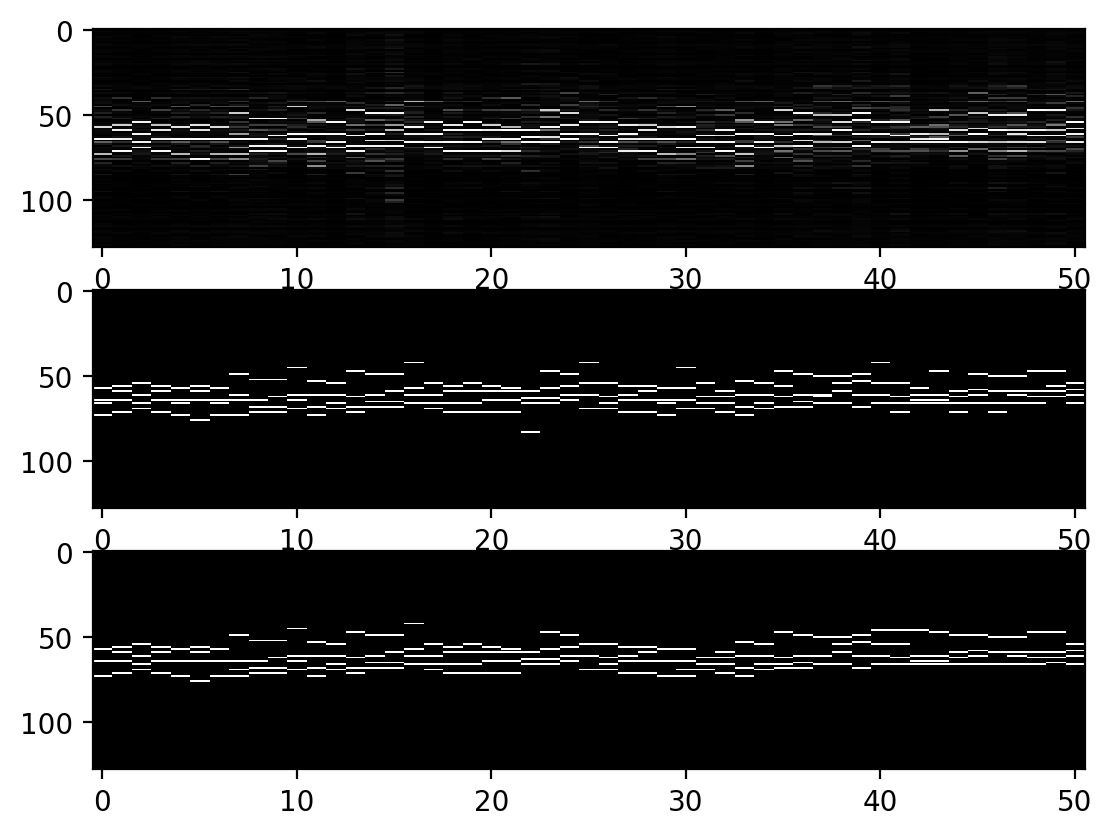

[[57, 64, 73, 0], [56, 59, 64, 71], [54, 61, 66, 69], [56, 59, 64, 71], [57, 64, 73, 0], [56, 59, 64, 76], [57, 64, 73, 0], [49, 64, 69, 73], [52, 64, 68, 71], [52, 62, 68, 71], [45, 61, 64, 69], [53, 61, 68, 73], [54, 61, 66, 69], [47, 62, 68, 71], [49, 61, 65, 68], [49, 59, 65, 68], [42, 57, 61, 66], [54, 61, 66, 69], [56, 59, 66, 71], [54, 59, 66, 71], [56, 59, 64, 71], [57, 59, 64, 71], [59, 63, 66, 0], [47, 57, 63, 66], [49, 56, 61, 64], [54, 61, 69, 0], [54, 62, 66, 69], [56, 61, 64, 71], [56, 59, 64, 71], [57, 64, 73, 0], [57, 64, 69, 73], [62, 66, 69, 0], [59, 62, 66, 71], [53, 61, 68, 73], [54, 61, 66, 69], [47, 62, 66, 68], [49, 61, 65, 68], [50, 61, 66, 0], [50, 54, 59, 66], [49, 53, 61, 68], [46, 54, 61, 66], [46, 54, 62, 66], [46, 61, 64, 66], [47, 61, 64, 66], [49, 59, 62, 66], [49, 58, 61, 66], [50, 59, 66, 0], [50, 59, 61, 66], [47, 59, 62, 66], [47, 59, 62, 65], [54, 58, 61, 66]] [[57, 64, 66, 73], [56, 59, 64, 71], [54, 61, 66, 69], [56, 59, 64, 71], [57, 64, 66, 73],

KeyboardInterrupt: 

In [9]:
bach = music21.corpus.parse('bach/bwv66.6')
sample_targets = torch.tensor([])
sample_labels = torch.tensor([])


for chord in bach.chordify().recurse().getElementsByClass(['Chord', 'Measure']):
        if 'Chord' in chord.classes:
            chord_zeroes = torch.zeros(128,dtype=torch.float)
            midis = np.array([p.midi for p in chord.pitches])
            chord_zeroes[midis] = 1.
            midis.resize(10)
            dense = torch.tensor(midis, dtype=torch.float)
            sample_targets = torch.cat([sample_targets, torch.unsqueeze(chord_zeroes, dim=0)], dim=0)
            sample_labels = torch.cat([sample_labels, torch.unsqueeze(dense, dim=0)], dim=0)

coords = model.encoder(sample_targets)
print(coords)
sample_outputs = model.decoder(coords)
x_hat = getTopKAsMultiHot(sample_outputs, 4)# + outs
print(x_hat)
fig, axs = plt.subplots(3, 1)
columns = torch.squeeze(x_hat) # torch.cat([columns, torch.unsqueeze(x_hat, dim=0)], dim=0)
axs[0].imshow(sample_outputs.T.detach().numpy(), cmap='gray', aspect='auto', interpolation='nearest')
axs[1].imshow(x_hat.T.detach().numpy(), cmap='gray', aspect='auto', interpolation='nearest')
axs[2].imshow(sample_targets.T.detach().numpy(), cmap='gray', aspect='auto', interpolation='nearest')

#plt.imshow(columns, extent=[*r0, *r1])
#columns = torch.squeeze(columns)
plt.show() #.imshow(sample_outputs.T.detach().numpy(), cmap='gray', aspect='auto', interpolation='nearest')
ts = tensor2midi(sample_targets).tolist()
cs = tensor2midi(columns).tolist()
print(ts, cs)
for i in range(len(x_hat)):
    print(ts[i])
    play_midi_chord(ts[i])
    play_midi_chord(cs[i])

In [3]:
import json
def plot_all_training_data(run_id, testset):
    labels = [json.dumps(ints, separators=(',', ':')) for ints in testset.uniques.tolist()]
    colors = torch.mean(testset.uniques.to(torch.float),1)
    run_dir = os.path.join(os.getcwd() , "outputs","data", run_id)
    config_file = os.path.join(run_dir, "config.json")
    losses_file = os.path.join(run_dir, "losses.tsv")
    embed_dir = os.path.join(run_dir, "embeddings")
    recons_dir = os.path.join(run_dir, "reconstructions")
    images_dir = os.path.join(run_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    #print(epochs)
    all_epochs = []
    all_bce = []
    all_kl = []

    with open(losses_file, "r") as file:
        for line in file:
            epoch, bce_loss, kl_loss = line.split('\t')
            all_epochs.append(int(epoch))
            all_bce.append(float(bce_loss))
            all_kl.append(float(kl_loss))
    with open(config_file, "r") as f :
        config = json.load(f)
    
    for i in range(len(all_epochs)):
        epoch = all_epochs[i]
        bce_loss = all_bce[i]
        kl_loss = all_kl[i]
        print(epoch, bce_loss, kl_loss)
        embed_file = os.path.join(embed_dir, f"{int(epoch):06}.pt")
        recons_file = os.path.join(recons_dir, f"{int(epoch):06}.pt")
        embeddings = torch.load(embed_file, map_location='cpu')
        reconstructions = torch.load(recons_file, map_location='cpu')
        print(f"loaded {len(embeddings)} from {embed_file} of shape {embeddings.shape}")
        img_filename = os.path.join(images_dir, f"{int(epoch):06}.png")
        sums = torch.tensor(all_bce) + torch.tensor(all_kl)
        #plot_details()
        plot_details(
            testset[:], 
            reconstructions,
            embeddings, 
            colors, 
            epoch, 
            i, 
            losses=[bce_loss, kl_loss],
            filename=img_filename, 
            all_losses=torch.stack([torch.tensor(all_bce), torch.tensor(all_kl), sums],-1),
            pitchwise_weights=(1/testset.get_pitchwise_freq()),
            chordwise_weights=(1/testset.get_chordwise_freq()),
            **config
        )
        #plot_interleaved(testset[:], reconstructions,embeddings, colors, epoch, losses=[bce_loss, kl_loss],filename=img_filename, all_losses=torch.stack([torch.tensor(all_bce), torch.tensor(all_kl), sums],-1))
        vid_filename = os.path.join(images_dir, f"{int(epoch):06}.mp4")
        img_glob = os.path.join(images_dir, '*.png')
    os.system(f"ffmpeg -framerate 20 -pattern_type glob -i '{img_glob}' -c:v libx264 -pix_fmt yuv420p {vid_filename}")


plot_all_training_data("0b92ebe2-e299-11ed-9760-acde48001122", testset)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hansen/dev/torchtuts/outputs/data/0b92ebe2-e299-11ed-9760-acde48001122/losses.tsv'

In [4]:
data = torch.load('all_multihot.pt')
ddata = torch.load('all_dense.pt')
flat_notes = torch.nonzero(ddata.view(-1, 1), as_tuple=True)
print(flat_notes)
print(np.min(flat_notes), np.max(flat_notes))
pitchwise_freq = torch.mean(data, dim=0)
chordwise_freq = torch.mm(data, pitchwise_freq.view([128,1])) 
print(torch.nonzero(1/pitchwise_freq))
#pitchwise_freq   = testset.get_pitchwise_freq() # torch.mean(torch.squeeze(testset[:]), dim=0) #
#chordwise_freq   = testset.get_chordwise_freq() # torch.mean(torch.squeeze(testset[:]), dim=0) #
#chordwise_freqstar   = torch.mean(testset.get_pitchwise_freq().view(50) * data, 1) # torch.mean(torch.squeeze(testset[:]), dim=0) #

print(pitchwise_freq.shape)
#print(testset.get_chordwise_weights())
#chordwise_weights = torch.mm(testset[:], pitchwise_weights.view([50,1])) / 50.
#print(data.shape)

print(pitchwise_freq)
print(chordwise_freq)
fig, axs = plt.subplots(4, 1)

axs[0].bar(range(0, 128), pitchwise_freq)
axs[1].bar(range(0, 128), 1/pitchwise_freq)
axs[2].bar(range(0, 6235), torch.squeeze(chordwise_freq))
axs[3].bar(range(0, 6235), torch.squeeze(1/chordwise_freq))
#axs[4].bar(range(0, 6235), torch.squeeze(1/chordwise_freqstar))

(tensor([    0,     1,    10,  ..., 62322, 62330, 62340]), tensor([0, 0, 0,  ..., 0, 0, 0]))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [4]:
def play_midi_chord(chordList):
    print( chordList)
    s = music21.stream.Stream()
    s.append(music21.tempo.MetronomeMark(number=100))
    c = music21.chord.Chord([int(chord) for chord in chordList])
    s.append(c)
    sp = music21.midi.realtime.StreamPlayer(s)
    sp.play()

In [17]:
def load_plot_widget(embedding, labels, colors):
    # create our callback function
    def update_point(trace, points, selector):
        point_idx = points.point_inds[0]
        midi_nums =  json.loads(scatter.customdata[point_idx])
        play_midi_chord([int(num) for num in midi_nums])
    
    x = embedding[:, 0]
    y = embedding[:, 1]
    f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers', customdata=labels)])
    f.update_layout(width=750)
    f.update_layout(height=750)
    scatter = f.data[0]
    scatter.marker.color = colors
    scatter.marker.size = [5] * len(embedding)
    f.layout.hovermode = 'closest'
    scatter.on_click(update_point)
    return f

In [ ]:
import uuid
import os
guid = str(uuid.uuid1())
parent_dir = os.path.join(os.getcwd() , "outputs","data", guid)
#os.mkdir(parent_dir)
embed_dir = os.path.join(parent_dir, "embeddings")
os.makedirs(embed_dir, exist_ok=True)
os.makedirs(embed_dir, exist_ok=True)

In [ ]:
a = torch.tensor(())
thing1 = torch.unsqueeze(testset[:], 0)
a = torch.cat([a,thing1],0)
print(a.shape)
a = torch.cat([a,thing1],0)
print(a.shape)

In [ ]:
weights =  (1 / torch.sum(torch.squeeze(testset[:]), dim=0))
print(weights.sum(), weights.mean(), weights.max(), weights.min(), weights.min()/weights.max())
weights = (1 / 0.004 * torch.mean(torch.squeeze(testset[:]), dim=0))
print(weights.sum(), weights.mean(), weights.max(), weights.min(), weights.min()/weights.max())
weights = (1 - torch.mean(torch.squeeze(testset[:]), dim=0))
print(weights.sum(), weights.mean(), weights.max(), weights.min(), weights.min()/weights.max())

print(1e3)
print(1/0.0010)
print(1/0.7658)


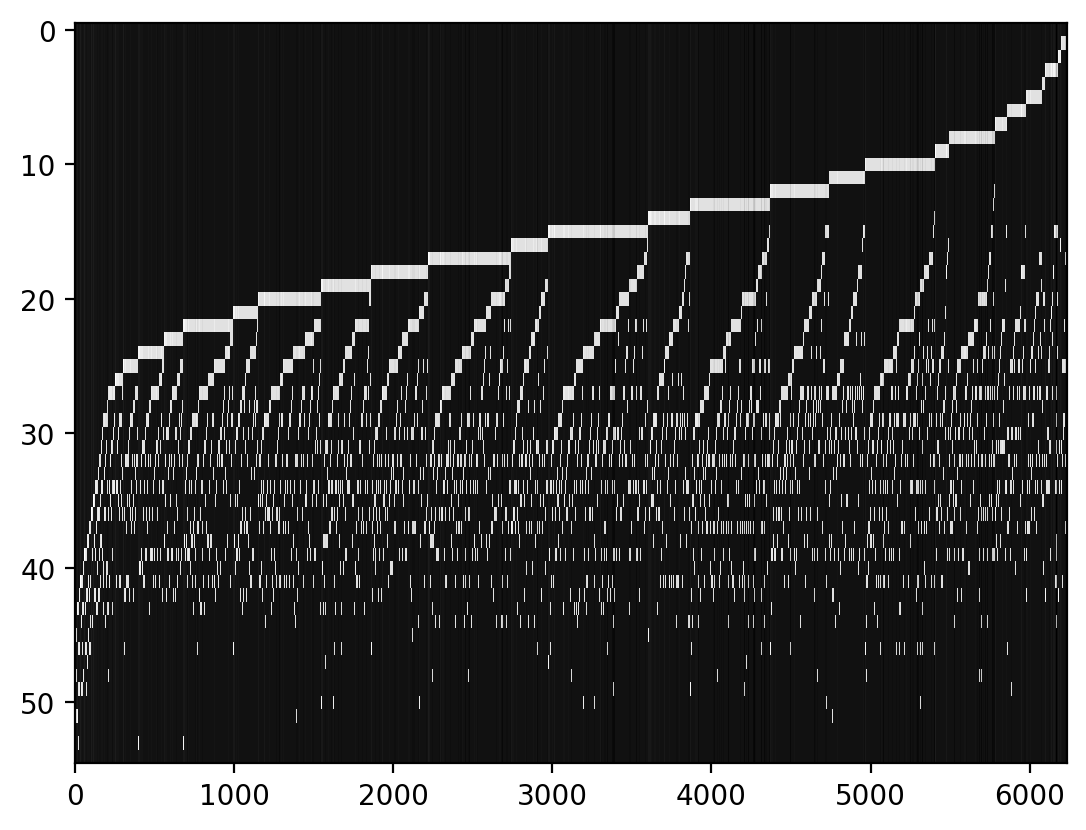

In [19]:
plt.imshow(torch.nn.functional.softmax(testset[:], dim=1).T, cmap='gray', aspect='auto', interpolation='nearest')

In [15]:

data = [
    [1],
    [1, 2],
    [1, 2, 3]
]
max_len = 3

# General Solution:
rectangle = np.zeros((len(data), max_len), dtype=np.int32)
trectangle = torch.zeros([len(data), max_len], dtype=torch.int)
for i in range(len(data)):
    trectangle[i, range(len(data[i]))] = data[i]

print(trectangle)

TypeError: can't assign a list to a torch.IntTensor

In [26]:
torch.exp(torch.tensor(-40))

tensor(4.2484e-18)

In [8]:

import uuid
import json

ORIGINAL_DIM = 128
LATENT_DIM = 3
MIN_MIDI = 35
MAX_MIDI = 90
DATA_LENGTH = MAX_MIDI - MIN_MIDI
INTERMEDIATE_DIMS = DATA_LENGTH*32
LEARNING_RATE = 1e-2
RHO  = 0.0074
BETA = 4
KLD_WEIGHT = 0. #
WEIGHT_MULT = 1.# 1e3
SPARSE_WEIGHT = 1
RUN_UUID = str(uuid.uuid1())
BATCH_SIZE=256
KL_SOFTMAX_DIM=1


'''config = {
    'original_dim': ORIGINAL_DIM,
    'intermediate_dim': 880,
    'latent_dim': LATENT_DIM,
    'data_length': DATA_LENGTH,
    'learning_rate': LEARNING_RATE,
    'kld_weight': KLD_WEIGHT,
    'bce_weight': WEIGHT_MULT,
    'sparsity_weight': SPARSE_WEIGHT,
    'batch_size': BATCH_SIZE,
    'class_weight_exponent': 0.125
}'''

run_id = 'f18d386e-ea7d-11ed-8bd1-acde48001122'
with open(f"/Users/hansen/dev/torchtuts/outputs/data/{run_id}/config.json") as f:
    config = json.load(f)
model = GaussianVAE(**config).to(device)
#model_path = f"./outputs/sparse_ae3300.pth"

model_path = f"/Users/hansen/dev/torchtuts/outputs/data/{run_id}/model_state/200.pth"
model.load_state_dict(torch.load(model_path))
#labels = [json.dumps([int(i) for i in ints if int(i) != 0], separators=(',', ':')) for ints in testset.uniques.tolist()]
#colors = torch.mean(testset.uniques.to(torch.float),1)
img = testset[:]    
print(img.shape)
img = img.view(img.size(0), -1)
print(img.shape)
img.to(device)
model.eval()
with torch.no_grad():
    reconstructions = model(img)
    embeddings = model.encoder(img)

print(torch.topk(reconstructions, 4))
#load_plot_widget(embeddings, labels, colors)
#plot_embedding_space(embeddings, colors)
#plot_interleaved(reconstructions, img,embeddings, colors, 4900, 42.5791282654)

torch.Size([223535, 128])
torch.Size([223535, 128])
torch.return_types.topk(
values=tensor([[0.1497, 0.1362, 0.1102, 0.0895],
        [0.1979, 0.1784, 0.1285, 0.0808],
        [0.0837, 0.0574, 0.0467, 0.0452],
        ...,
        [0.9036, 0.6557, 0.6045, 0.4994],
        [0.9425, 0.9253, 0.8579, 0.6973],
        [0.8834, 0.8713, 0.7959, 0.7543]]),
indices=tensor([[ 44, 127,  49,  40],
        [126, 123,  32,  44],
        [ 40, 125,  32,  31],
        ...,
        [  0,   1,   5,   7],
        [ 15,   3,   0,   1],
        [  3,  12,   1,  18]]))


In [31]:
cols = plot_reconstructed(model, 2, r0=(-10, 10), n=30)
print(cols.shape)
cols = cols

TypeError: plot_reconstructed() missing 1 required positional argument: 'dim2'

[52, 60, 64, 68]
[52, 56, 60, 68]
[52, 56, 60, 64]
[48, 55, 56, 64]
[48, 52, 56, 64]
[40, 52, 60, 68]
[37, 38, 42, 49]
[34, 38, 42, 49]
[34, 37, 38, 42]
[30, 51, 54, 58]
[26, 30, 34, 42]
[22, 30, 34, 50]
[22, 26, 34, 42]
[22, 26, 30, 34]
[18, 22, 30, 34]
[13, 34, 37, 42]
[13, 22, 34, 42]


In [14]:
midis = torch.topk(reconstructions, 4).indices + MIN_MIDI
num_chords = len(midis)
src =torch.ones([num_chords, 128])
zeros = torch.zeros([num_chords, 128], dtype=src.dtype)
zeros.scatter_(1, midis, src)[:, MIN_MIDI:MAX_MIDI].shape


torch.Size([6235, 55])